 # Construção de modelo para prever fraude em transações financeiras
 Dataset coletado: https://www.kaggle.com/datasets/chitwanmanchanda/fraudulent-transactions-data

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount -
amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


1- Primeiro passo: Conectar a base no banco de dados SQL Server

In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Conenctando no SQL Server para extrair a base
import pyodbc
conn =pyodbc.connect(driver='{SQL Server Native Client 11.0}', 
                      host='localhost', database='Fraude', trusted_connection='yes')
cursor=conn.cursor()
cursor.execute('SELECT * FROM Fraude.dbo.houses_to_rent_sql')


In [ ]:
df=pd.read_sql(sql='SELECT * FROM Fraude.dbo.houses_to_rent_sql',con=conn)

In [5]:
df=pd.read_csv('PS_20174392719_1491204439457_log.csv', sep=',')

In [6]:
pd.set_option('display.float_format', str)

In [ ]:
2- O próximo passo é realizar o tratamento dos dados

In [8]:
# Resumo do comportamento dos dados
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df[ (df["isFraud"]==1)].head(20)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0
681,1,CASH_OUT,20128.0,C1118430673,20128.0,0.0,C339924917,6268.0,12145.85,1,0
724,1,CASH_OUT,416001.33,C749981943,0.0,0.0,C667346055,102.0,9291619.62,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.0,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,1,0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.0,1,0


In [9]:
# Tipo dos dados em cada variável
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [10]:
# Proporção para os casos que foram fraudes e não fraudes
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [11]:
# Verificar se há valores NA
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [14]:
fraud=df[df['isFraud']==1]

In [57]:
no_fraud=df[df['isFraud']==0]

In [17]:
# Proporção para os casos que foram flegados como fraudes e não fraudes
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

Possíveis perguntas de negócio a serem respondidas:

1- As contas de origem que ficaram zeradas após as transações são todos casos de fraudes?

2- Existe mais de uma fraude em uma mesma conta de origem?

3- Existe mais de uma fraude em uma mesma conta de destino?

In [19]:
obs=[]

In [20]:
# objeyivo: verificar se todas as contas de origem que ficaram zeradas após a transação são fraudes
for i in df['newbalanceOrig']:
    if i==0:
        x=1
        obs.append(x)
    else:
        x=0
        obs.append(x)

In [21]:
df['Obs']=obs

In [24]:
pd.crosstab(df['Obs'], df['isFraud'], rownames=['Obs'], colnames=['isFraud'])

isFraud,0,1
Obs,,
0,2752894,160
1,3601513,8053


In [25]:
df.shape

(6362620, 12)

In [26]:
8053/6362620

0.0012656735747223627

In [27]:
#Portanto, apenas 0,1% dos casos em que a conta de origem ficou zerada após a transferência foram fraudes 

In [ ]:
# Em seguida, coletar as contas que de origem que foram mais de uma vez fraudadas, se houver

In [28]:
dupli_orig_fraud=df[df['isFraud']==1]

In [29]:
dupli_orig_fraud.groupby('nameOrig')['isFraud'].count().sort_values(ascending=False)

nameOrig
C99979309      1
C164780972     1
C1627918307    1
C1628056782    1
C162812306     1
              ..
C356480504     1
C356571967     1
C356706674     1
C356781229     1
C1000036340    1
Name: isFraud, Length: 8213, dtype: int64

In [30]:
dupli_orig_fraud2=dupli_orig_fraud[dupli_orig_fraud.groupby('nameOrig')['isFraud'].transform('count') > 1]

In [31]:
len(dupli_orig_fraud2['nameOrig'].unique())

0

In [33]:
# Não há contas que sofreram fraude mais de uma vez

In [32]:
#print(dupli_orig_fraud.groupby('nameOrig')['isFraud'].count().sort_values(ascending=False))

In [ ]:
# Em seguida, coletar as contas que de destino que foram mais de uma vez fraudadas, se houver

In [34]:
dupli_orig_fraud.groupby('nameDest')['isFraud'].count().sort_values(ascending=False)

nameDest
C935310781     2
C385133759     2
C200064275     2
C1656842502    2
C1655359478    2
              ..
C359739038     1
C359887652     1
C360215463     1
C360497591     1
C1000039615    1
Name: isFraud, Length: 8169, dtype: int64

In [35]:
dupli_dest_fraud2=dupli_orig_fraud[dupli_orig_fraud.groupby('nameDest')['isFraud'].transform('count') > 1]

In [36]:
len(dupli_dest_fraud2['nameDest'].unique())

44

In [37]:
# 44 contas  de destino tiveram mais de uma fraude

In [ ]:
# Transformar algumas variáveis como categóricas

In [40]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
Obs                 int64
dtype: object

In [41]:
cat=['type', 'isFraud', 'isFlaggedFraud']

In [42]:
for i in cat:
    df[i]=df[i].astype('category')

Análise das variáveis independentes categóricas com a variável dependente

In [43]:
# Analisar a relação entre a variável "type" e "isFraud"
pd.crosstab(df.type, df.isFraud)

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


In [44]:
#os únicos tipos que tiveram fraudes foram "CASH_OUT" e "TRANSFER"

In [45]:
# Analisar a relação entre a variável "isFlaggedFraud" e "isFraud"
pd.crosstab(df.isFlaggedFraud, df.isFraud)

isFraud,0,1
isFlaggedFraud,,
0,6354407,8197
1,0,16


In [46]:
# todas as tranferências que foram flegadas como fraudes, dado que houve tentativa de transferência de mais de 200.000,
# foram de fato fraudes

In [48]:
Análise das variáveis independentes numéricas com a variável dependente

step                 int64
type              category
amount             float64
nameOrig            object
oldbalanceOrg      float64
newbalanceOrig     float64
nameDest            object
oldbalanceDest     float64
newbalanceDest     float64
isFraud           category
isFlaggedFraud    category
Obs                  int64
dtype: object

In [52]:
#indicadores para "amount"
print("média",df.groupby("isFraud")["amount"].mean())
print("mediana", df.groupby("isFraud")["amount"].median())
print("desvio padrão",df.groupby("isFraud")["amount"].std())

média isFraud
0   178197.04172739814
1    1467967.299140387
Name: amount, dtype: float64
mediana isFraud
0    74684.72
1   441423.44
Name: amount, dtype: float64
desvio padrão isFraud
0   596236.9813472016
1   2404252.947240167
Name: amount, dtype: float64


In [ ]:
# dado que há uma alta diferença entre a média e mediana e o alto valor do disvio padrão,
# pode-se imaginar que há valores extremos. Porém nota-se que para os casos em
# que houve fraude o valor da transferência foi em média maior que os casos que não teve fraude 

In [50]:
#indicadores para "oldbalanceOrg"
print("média",df.groupby("isFraud")["oldbalanceOrg"].mean())
print("mediana", df.groupby("isFraud")["oldbalanceOrg"].median())
print("desvio padrão",df.groupby("isFraud")["oldbalanceOrg"].std())

média isFraud
0    832828.7117272562
1   1649667.6057116783
Name: oldbalanceOrg, dtype: float64
mediana isFraud
0     14069.0
1   438983.45
Name: oldbalanceOrg, dtype: float64
desvio padrão isFraud
0    2887144.030332991
1   3547719.4391091308
Name: oldbalanceOrg, dtype: float64


In [ ]:
# dado que há uma alta diferença entre a média e mediana e o alto valor do disvio padrão,
# pode-se imaginar que há valores extremos. Porém nota-se que para os casos em
# que houve fraude o valor na conta de origem antes da transferência foi em média maior que os casos que não teve fraude 

In [51]:
#indicadores para "newbalanceOrig"
print("média",df.groupby("isFraud")["newbalanceOrig"].mean())
print("mediana", df.groupby("isFraud")["newbalanceOrig"].median())
print("desvio padrão",df.groupby("isFraud")["newbalanceOrig"].std())

média isFraud
0    855970.2281087907
1   192392.63183611343
Name: newbalanceOrig, dtype: float64
mediana isFraud
0   0.0
1   0.0
Name: newbalanceOrig, dtype: float64
desvio padrão isFraud
0   2924986.9646495897
1    1965666.455719133
Name: newbalanceOrig, dtype: float64


In [ ]:
# dado que há uma alta diferença entre a média e mediana e o alto valor do disvio padrão,
# pode-se imaginar que há valores extremos. Porém nota-se que para os casos em
# que houve fraude o valor na conta de origem depois da transferência foi em média menor que os casos que não teve fraude 

In [ ]:
# As fraudes predominam em contas com mais dinheiro na conta e após a transferência
# o valor final da conta é menor do que os casos onde não gouve fraude

In [53]:
#indicadores para "oldbalanceDest"
print("média",df.groupby("isFraud")["oldbalanceDest"].mean())
print("mediana", df.groupby("isFraud")["oldbalanceDest"].median())
print("desvio padrão",df.groupby("isFraud")["oldbalanceDest"].std())

média isFraud
0   1101420.8745694289
1    544249.6190746377
Name: oldbalanceDest, dtype: float64
mediana isFraud
0   133311.8
1        0.0
Name: oldbalanceDest, dtype: float64
desvio padrão isFraud
0   3399201.7933785026
1   3336420.9509249586
Name: oldbalanceDest, dtype: float64


In [ ]:
# dado que há uma alta diferença entre a média e mediana e o alto valor do disvio padrão,
# pode-se imaginar que há valores extremos. Porém, observa-se que em média as contas de destino antes da transferência
# possuem menos dinheiro que as contas de destino que não tiveram fraude

In [54]:
#indicadores para "newbalanceDest"
print("média",df.groupby("isFraud")["newbalanceDest"].mean())
print("mediana", df.groupby("isFraud")["newbalanceDest"].median())
print("desvio padrão",df.groupby("isFraud")["newbalanceDest"].std())

média isFraud
0   1224925.6845633048
1   1279707.6171459865
Name: newbalanceDest, dtype: float64
mediana isFraud
0   214881.7
1    4676.42
Name: newbalanceDest, dtype: float64
desvio padrão isFraud
0    3673815.709922623
1   3908816.5338157546
Name: newbalanceDest, dtype: float64


In [ ]:
#Percebe-se que não há diferenças significativas entre os casos que houveram fraude e os que não houveram fraude
#, embora a mediana mostre que as situações que não ocorreram fraude apresentam valores maiores.

In [55]:
df=df.drop(columns=["Obs"])

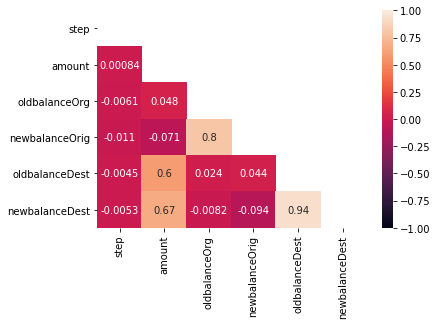

In [56]:
#Heatmap para analisar a correlação das variáveis
mask = np.triu(np.ones_like(df.corr(method='spearman'), dtype=bool))

# generate heatmap
sns.heatmap(df.corr(method='spearman'), annot=True, mask=mask, vmin=-1, vmax=1)

In [69]:
# Eliminando coluans não relevantes ao modelo
df_modelo=df.drop(columns=["step", "nameOrig", "nameDest"])

In [70]:
# transformando a variável "type" em dummies
df_dummies=pd.get_dummies(data=df_modelo, columns=['type'])

In [ ]:
# Devido ao grande tamanho da base, o computador local não foi capaz de criar modelos. 
# Dessa forma foi selecionado uma amostra da base contendo a mesma proporção de fraudes e não fraudes da base original

In [92]:
df_dummies.size

76351440

In [120]:
76351440*0.01

763514.4

In [144]:
df_dummies_amostra=df_dummies.sample(n=763514, random_state=111)

In [132]:
df_dummies_amostra.size

916212

In [161]:
df_dummies_amostra.groupby('isFraud')['isFlaggedFraud'].count()

isFraud
0    762538
1       976
Name: isFlaggedFraud, dtype: int64

In [163]:
# Na base da amostra apenas 0,1% dos casos são fraudes
976/916212

0.001065255639524477

In [162]:
df_dummies.groupby('isFraud')['isFlaggedFraud'].count()

isFraud
0    6354407
1       8213
Name: isFlaggedFraud, dtype: int64

In [164]:
df_dummies.size

76351440

In [165]:
# Na base orginal apenas 0,1% dos casos são fraudes
8213/76351440

0.00010756837068167935

In [145]:
x=df_dummies_amostra.drop(columns=['isFraud'])
y=df_dummies_amostra['isFraud']

In [98]:
# normalização dos dados
from sklearn.preprocessing import MinMaxScaler


In [146]:
x_norm=MinMaxScaler(feature_range = (0, 1)).fit_transform(x)

In [82]:
# divisão entre dados treino e teste
from sklearn.model_selection import train_test_split 

In [147]:
x_train, x_test, y_train, y_test=train_test_split(x_norm, y, test_size=0.33, random_state=222)

In [85]:
import statsmodels.api as sm

In [148]:
# criação de modelo de regressão logística do pacto statsmodel
bin_model = sm.GLM(y_train, x_train, family=sm.families.Binomial())

In [149]:
bin_results=bin_model.fit()

C:\Users\allima\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\allima\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\allima\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\allima\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\allima\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)


In [201]:
x_dummies=df_dummies.drop(columns=['isFraud'])

In [206]:
# Resumo do modelo gerado
# Pode-se afirmar que todas as variáveis apresentam coeficientes diferentes de 0 pois o p valor do cálculo é menor que 5%.
# Portanto todas as variáveis são significativas ao modelo
print(bin_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                isFraud   No. Observations:               511554
Model:                            GLM   Df Residuals:                   511544
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 19 Aug 2022   Deviance:                          nan
Time:                        16:52:40   Pearson chi2:                 1.95e+18
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2.184e+16      2e+07  -1.09e+09      0.0

In [154]:
# Teste de previsão
bin_pred=bin_results.predict(x_test)

C:\Users\allima\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [167]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [157]:
# matriz de confusão
print(confusion_matrix(y_test,bin_pred))

[[251550     88]
 [   116    206]]


In [159]:
# Percebe-se  que embora o nível de acurácia é alto os valores de precisão e recall para os acertos quando o casos é fraude
# não é muito assertivo. Portanto o algoritmo prevê bem quando não é fraude mas acerta menos quando é fraude
print(classification_report(y_test,bin_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251638
           1       0.70      0.64      0.67       322

    accuracy                           1.00    251960
   macro avg       0.85      0.82      0.83    251960
weighted avg       1.00      1.00      1.00    251960



In [168]:
#Valor da curva roc é alto
roc_auc_score(y_test,bin_pred)

0.8197009220432446

In [169]:
from sklearn.ensemble import RandomForestClassifier

In [176]:
# Elaboração do modelo usando Random Forest
random_model=RandomForestClassifier(random_state=333).fit(x_train,y_train)

In [171]:
random_pred=random_model.predict(x_test)

In [172]:
# matriz de confusão
confusion_matrix(y_test,random_pred)

array([[251631,      7],
       [    81,    241]], dtype=int64)

In [174]:
# Percebe-se que esse modelo apresenta um valor alto de precisão para os casos que são fraudes e maior que o modelo anterior
print(classification_report(y_test,random_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251638
           1       0.97      0.75      0.85       322

    accuracy                           1.00    251960
   macro avg       0.99      0.87      0.92    251960
weighted avg       1.00      1.00      1.00    251960



In [179]:
# O valor da curva roc é maior que o modelo anterior
roc_auc_score(y_test, random_pred)

0.8742096936153823

In [ ]:
# Pelo algoritmo Random Forest é possível verificar quais variáveis impactam mais ao modelo

In [ ]:
x_dummies=df_dummies.drop(columns=['isfraud'])

In [209]:
x_dummies.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFlaggedFraud', 'type_CASH_IN', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [207]:
random_model.feature_importances_

array([1.84085510e-01, 2.75451753e-01, 2.92580619e-02, 9.88599805e-02,
       3.24557783e-01, 0.00000000e+00, 2.15553967e-03, 2.36939343e-02,
       2.47100965e-04, 5.88220874e-03, 5.58081282e-02])

In [ ]:
# Percebe-se que a variável "isFlaggedFraud" é mais significativo ao modelo, seguido da variável
# 'newbalanceDest', 'oldbalanceOrg' e 'amount'

In [211]:
from sklearn.ensemble import GradientBoostingClassifier

In [212]:
# Elaboração do modelo usando Gradient Boosting
gb_model=GradientBoostingClassifier(random_state=333).fit(x_train,y_train)

In [213]:
gb_pred=gb_model.predict(x_test)

In [214]:
# matriz de confusão
confusion_matrix(y_test,gb_pred)

array([[251630,      8],
       [   154,    168]], dtype=int64)

In [215]:
# Percebe-se que esse modelo apresenta um valor alto de precisão para os casos que são fraudes,
# porém não é maior que o modelo com Random Forest
print(classification_report(y_test,gb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251638
           1       0.95      0.52      0.67       322

    accuracy                           1.00    251960
   macro avg       0.98      0.76      0.84    251960
weighted avg       1.00      1.00      1.00    251960



In [216]:
# O valor da curva roc é menor que o modelo anterior
roc_auc_score(y_test, gb_pred)

0.7608536693670032

In [217]:
from xgboost import XGBClassifier

In [218]:
# Elaboração do modelo usando XGB
xgb_model=XGBClassifier(random_state=333).fit(x_train,y_train)

In [219]:
xgb_pred=xgb_model.predict(x_test)

In [220]:
# matriz de confusão
confusion_matrix(y_test,xgb_pred)

array([[251629,      9],
       [    78,    244]], dtype=int64)

In [221]:
# Percebe-se que esse modelo apresenta uma precisão 1%menor que o modelo com random forest, porém o recall é 1% maior.
# Comparando o f1-score eles têm o mesmo valor
print(classification_report(y_test,xgb_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251638
           1       0.96      0.76      0.85       322

    accuracy                           1.00    251960
   macro avg       0.98      0.88      0.92    251960
weighted avg       1.00      1.00      1.00    251960



In [222]:
# O valor da curva roc é menor que o modelo anterior
roc_auc_score(y_test, xgb_pred)

0.8788641047459529

In [223]:
# A seguir pela função RandomizedSearchCV buscará encontrar os melhores valores dos parâmetros para os modelos 
# Random Forest e XGBoost
from sklearn.model_selection import RandomizedSearchCV

In [227]:
# Valores dos parâmetros testados
param_grid = {
    'max_depth': [None,4, 5, 6],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2,3,4, 5, 6],
    'n_estimators': [100,200]}

In [228]:
# Produção do modelo
random_model2 = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                             param_distributions = param_grid, 
                             random_state = 333).fit(x_train, y_train)

In [229]:
# O Melhor modelo gerado foi com o min_samples_split igual a 5. Os outros parâmetros se manteram default
random_model2.best_estimator_

RandomForestClassifier(min_samples_split=5)

In [230]:
random_model2_pred=random_model2.predict(x_test)

In [231]:
# matriz de confusão
confusion_matrix(y_test,random_model2_pred)

array([[251631,      7],
       [    85,    237]], dtype=int64)

In [232]:
# Mesmo tentando buscar os melhores valores dos parâmetros, o modelo gerado não apresentou indicadores melhores que o anterior
print(classification_report(y_test,random_model2_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251638
           1       0.97      0.74      0.84       322

    accuracy                           1.00    251960
   macro avg       0.99      0.87      0.92    251960
weighted avg       1.00      1.00      1.00    251960



In [239]:
# Valores dos parâmetros testados para o modelo XGBoost
param_grid_xgb = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
    "learning_rate" : [0.03,0.05, 0.1, 0.25, 0.5],
    'n_estimators': [100,200]
        }

In [240]:
# Produção do modelo
xgb_model2 = RandomizedSearchCV(estimator = XGBClassifier(), 
                             param_distributions = param_grid_xgb, 
                             random_state = 333).fit(x_train, y_train)

In [244]:
# Melhores valores dos estimadores
xgb_model2.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [241]:
xgb_model2_pred=xgb_model2.predict(x_test)

In [242]:
# matriz de confusão
confusion_matrix(y_test,xgb_model2_pred)

array([[251633,      5],
       [    78,    244]], dtype=int64)

In [243]:
# Percebe-se que o modelo gerado apresentou o melhores nível de precisão para os casos que sõa fraudes
print(classification_report(y_test,xgb_model2_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251638
           1       0.98      0.76      0.85       322

    accuracy                           1.00    251960
   macro avg       0.99      0.88      0.93    251960
weighted avg       1.00      1.00      1.00    251960



In [245]:
# Portanto o melhor modelo foi o xgb_model2, assim salvaremos ele
import pickle

In [246]:
with open('modelo_fraude.pkl', 'wb') as file:
    pickle.dump(xgb_model2, file)